## Environment Setup

In [24]:
#!pip install geopandas 
#!pip install folium

In [25]:
import pandas as pd
pd.options.mode.chained_assignment = None

import geopandas as gpd
import folium
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *

## Datasets

In [26]:
gas_stations_state = pd.read_csv("./clean_data/gas_stations_state.csv")

ev_stations_state = pd.read_csv('clean_data/population_states_stations_2025.csv')

complete = ev_stations_state.merge(gas_stations_state, on = 'state', how="left")

complete.head(10)


,state,inhabitants,area,population_density,number_of_charging_points,number_fast_charging_stations,number_regular_charging_stations,number_of_electric_cars,index,number_cars,number_non_electric_cars,cars_per_ev_station,number_of_gas_stations
0,Baden-Württemberg,11280257,3574785,316,93695,14271,79424,447516,871,8662899,8215383,4.776306,1.132
1,Bayern,13369393,7054158,190,111983,19649,92334,508858,879,10907517,10398659,4.544065,1.281
2,Berlin,3755251,89112,4214,18854,2325,16529,77486,887,1492346,1414860,4.109791,109.000
3,Brandenburg,2573135,2965438,87,12340,2897,9443,57883,895,1891574,1833691,4.690681,113.000
4,Bremen,684864,41961,1632,3969,537,3432,15280,903,349764,334484,3.849836,25.000
5,Hamburg,1892122,75509,2506,14077,2157,11920,63864,911,955424,891560,4.536762,103.000
6,Hessen,6391360,2111562,303,41655,7504,34151,247801,919,4746596,4498795,5.948890,522.000
7,Mecklenburg-Vorpommern,1628378,2329490,70,6887,1677,5210,26345,927,1124068,1097723,3.825323,102.000
8,Niedersachsen,8140242,4770990,171,54124,11727,42397,271977,935,6144748,5872771,5.025072,839.000
9,Nordrhein-Westfalen,18139116,3411272,532,101969,17163,84806,654721,943,12737736,12083015,6.420785,1.179


In [27]:
# Load GeoJSON file
geojson_url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/2_hoch.geo.json"
germany_states = gpd.read_file(geojson_url)

# Display the first few rows
germany_states.head(5)



,id,name,type,geometry
0,DE-BW,Baden-Württemberg,State,"MULTIPOLYGON (((9.65046 49.77634, 9.65097 49.7..."
1,DE-BY,Bayern,State,"POLYGON ((10.13386 50.55, 10.1398 50.54252, 10..."
2,DE-BE,Berlin,State,"POLYGON ((13.16181 52.59442, 13.1801 52.59416,..."
3,DE-BB,Brandenburg,State,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,DE-HB,Bremen,State,"POLYGON ((8.98545 53.12822, 8.97316 53.12799, ..."


Merge the two datasets

In [28]:
# Merge the two datasets
# Ensure the state names match between your dataset and the GeoJSON
complete['state'] = complete['state'].str.strip()

# Merge dataset with GeoJSON
germany_states = germany_states.merge(complete, left_on="name", right_on="state", how="left")



Renames the states to match the names of the map

In [29]:
germany_states['state_abbreviation'] = germany_states['state'].map(german_states_abbreviations)


In [30]:
germany_states["state"] = germany_states["state"].replace(state_name_mapping)
germany_states["name"] = germany_states["name"].replace(state_name_mapping)

In [31]:
germany_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                16 non-null     object  
 1   name                              16 non-null     object  
 2   type                              16 non-null     object  
 3   geometry                          16 non-null     geometry
 4   state                             16 non-null     object  
 5   inhabitants                       16 non-null     int64   
 6   area                              16 non-null     int64   
 7   population_density                16 non-null     int64   
 8   number_of_charging_points         16 non-null     int64   
 9   number_fast_charging_stations     16 non-null     int64   
 10  number_regular_charging_stations  16 non-null     int64   
 11  number_of_electric_cars           16 non-null     in

In [32]:
columns = ['inhabitants', 'area',
       'population_density', 'number_of_charging_points',
       'number_of_electric_cars', 'number_fast_charging_stations']
correlation_matrix = germany_states[columns].corr(numeric_only=True)

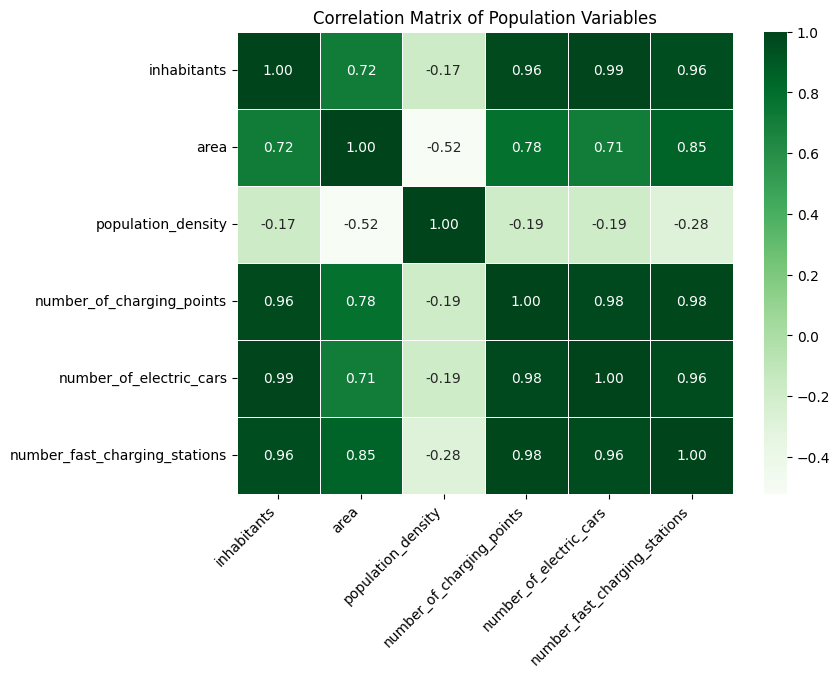

In [33]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Matrix of Population Variables")
plt.xticks(rotation=45, ha="right")
# Show the plot
plt.show()

## Add new columns with some ratios

In [34]:
germany_states ['ev_per_stations'] = germany_states ['number_of_electric_cars'] / germany_states ['number_of_charging_points']

In [35]:
germany_states ['ev_per_inhabitants'] = germany_states ['number_of_electric_cars'] / germany_states ['inhabitants']

In [36]:
germany_states ['ice_per_gas_station'] = germany_states ['number_non_electric_cars'] / germany_states ['number_of_gas_stations']

In [37]:
germany_states.to_csv('./clean_data/all_together.csv', index = False)

In [38]:
#Calculate the percentage of fast stations
germany_states['fast_percentage'] = (germany_states['number_fast_charging_stations'] / 
                           (germany_states['number_fast_charging_stations'] + germany_states['number_regular_charging_stations'])) * 100

## Comparisons

Plots maps with some comparisons

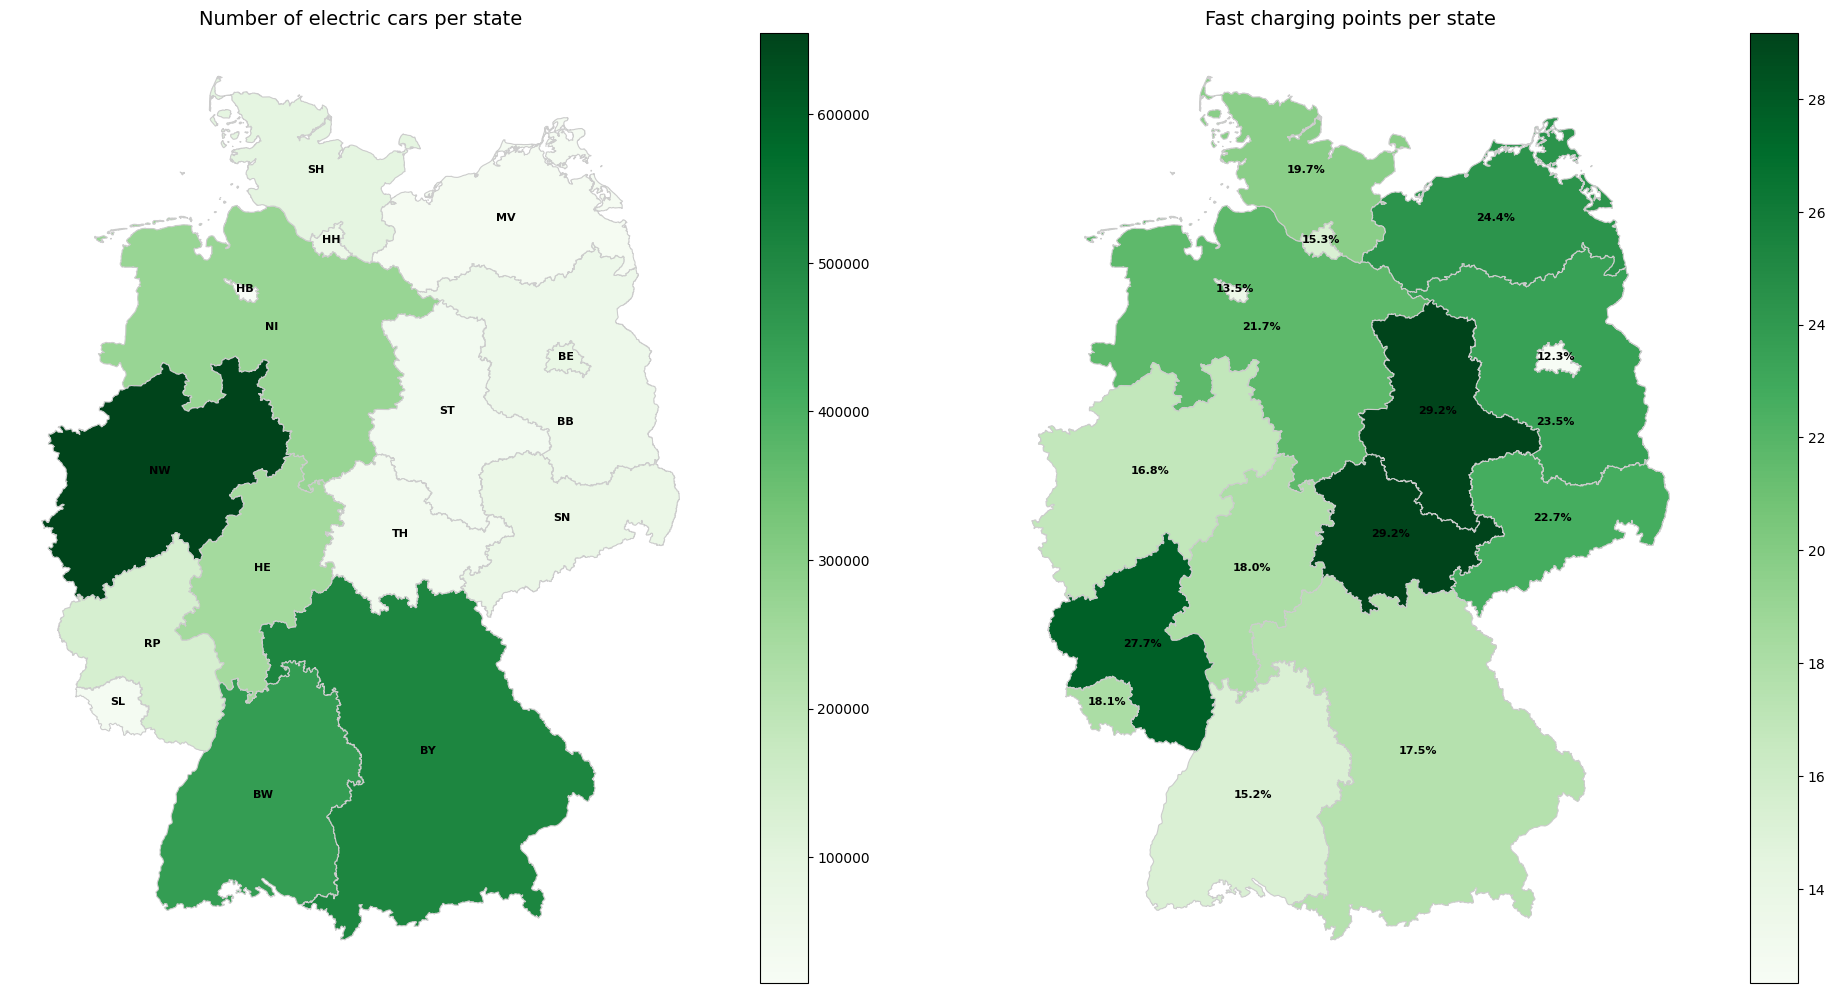

In [39]:
# Step 2: Plot the map
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Map 1: Electric cars
germany_states.plot(
    column="number_of_electric_cars",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[0]
)

# Add labels to states on the first map
for idx, row in germany_states.iterrows():
    centroid = row["geometry"].centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    if row['state'] == 'Brandenburg': # Bradenburg and Berlin have almost the same center
        south_point = row["geometry"].bounds[1]
        adjusted_y = (centroid_y + south_point) / 2
        adjusted_x = centroid_x
    else:
        adjusted_x, adjusted_y = centroid_x, centroid_y

    axes[0].annotate(
        row['state_abbreviation'],
        xy=(adjusted_x, adjusted_y),
        ha="center",
        fontsize=8,
        color="black",
        weight="bold"
    )

axes[0].set_title("Number of electric cars per state", fontsize=14)
axes[0].axis("off")

# Map 2: Fast Stations
germany_states.plot(
    column="fast_percentage",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[1]
)

# Add labels to states on the second map
for idx, row in germany_states.iterrows():
    centroid = row["geometry"].centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    if row['state'] == 'Brandenburg':
        south_point = row["geometry"].bounds[1]
        adjusted_y = (centroid_y + south_point) / 2
        adjusted_x = centroid_x
    else:
        adjusted_x, adjusted_y = centroid_x, centroid_y

    axes[1].annotate(
        f"{row['fast_percentage']:.1f}%",
        xy=(adjusted_x, adjusted_y),
        ha="center",
        fontsize=8,
        color="black",
        weight="bold"
    )

axes[1].set_title("Fast charging points per state", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()



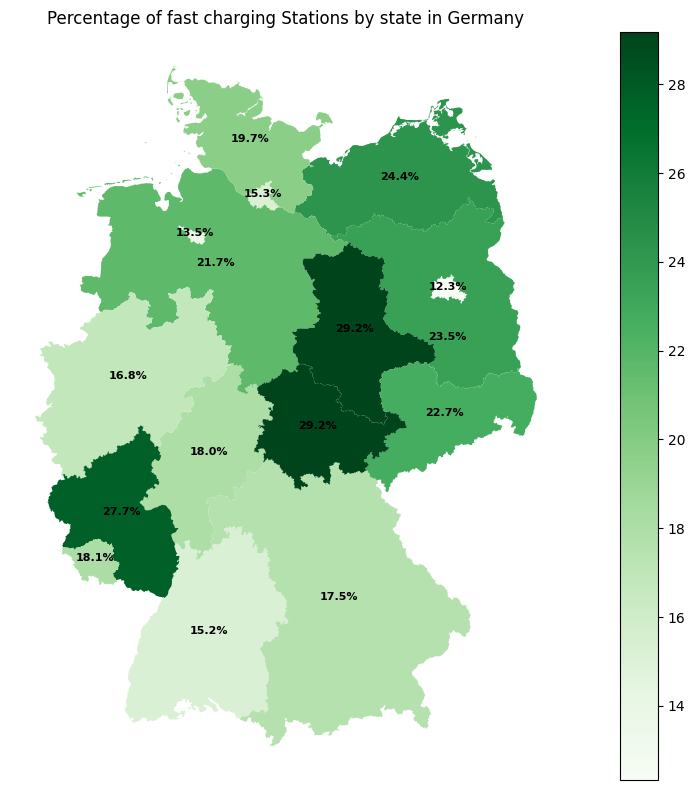

In [40]:
# Step 2: Plot the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map with color scale based on the fast_percentage
germany_states.plot(ax=ax, column='fast_percentage', cmap='Greens', legend=True,
         legend_kwds={'orientation': "vertical"})

# Step 3: Add labels with the exact percentage of fast stations
for idx, row in germany_states.iterrows():
    # Get the centroid of the state
    centroid = row["geometry"].centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    # Check if the centroid has already been used
    if (row['state'] == 'Brandenburg'):
        # If used, adjust the position (move slightly south)
        # This moves the annotation to a point between the center and the southernmost point
        south_point = row["geometry"].bounds[1]  # southernmost y-coordinate
        adjusted_y = (centroid_y + south_point) / 2  # midpoint between center and south
        adjusted_x = centroid_x  # keep x the same
    else:
        # If not used, use the original centroid
        adjusted_x, adjusted_y = centroid_x, centroid_y

    
    # Annotate the plot
    ax.annotate(
        f"{row['fast_percentage']:.1f}%",
        xy=(adjusted_x, adjusted_y),
        ha="center",
        fontsize=8,
        color="black",
        weight="bold"
    )

# Title and formatting
plt.title("Percentage of fast charging Stations by state in Germany")
plt.axis("off")  # Optionally hide axis
plt.tight_layout()
plt.show()


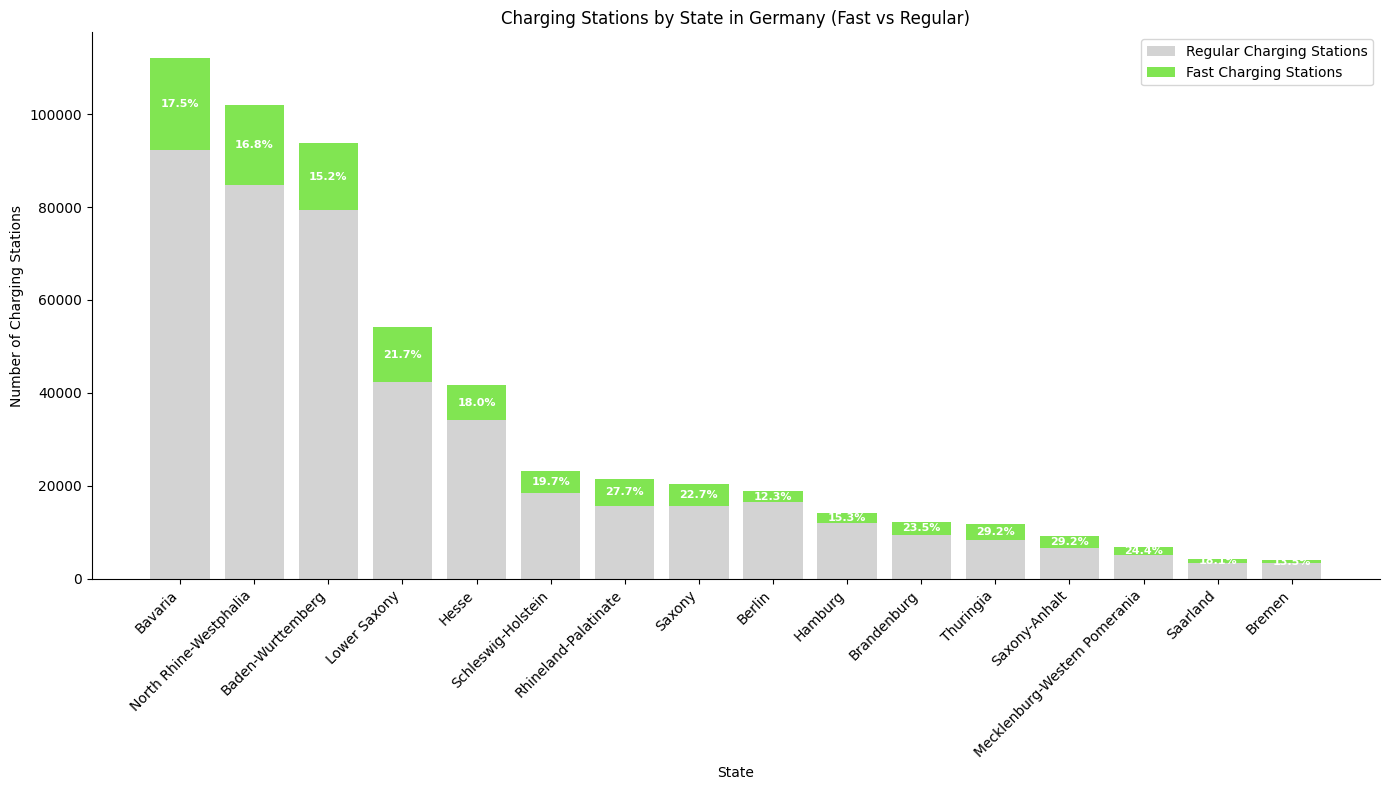

In [41]:
# Step 1: Prepare the data
germany_states_sorted = germany_states.sort_values(by='number_of_charging_points', ascending=False)

states = germany_states_sorted['state']
fast = germany_states_sorted['number_fast_charging_stations']
regular = germany_states_sorted['number_regular_charging_stations']

# Step 2: Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(states, regular, label='Regular Charging Stations', color='lightgray')
ax.bar(states, fast, bottom=regular, label='Fast Charging Stations', color='#81E552')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Step 3: Annotate each bar with the fast percentage
for idx, (f, r) in enumerate(zip(fast, regular)):
    total = f + r
    percentage = (f / total) * 100 if total > 0 else 0
    ax.text(idx, r + f/2, f"{percentage:.1f}%", ha='center', va='center', fontsize=8, color='white', weight='bold')

# Formatting
plt.title("Charging Stations by State in Germany (Fast vs Regular)")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

plt.show()


In [42]:
germany_states["charging_points_per_km2"] = germany_states["number_of_charging_points"] / (germany_states["area"] / 1e6)

In [43]:
germany_states["charging_points_per_1000_inhabitants"] = ((germany_states["number_of_charging_points"] / germany_states["inhabitants"])*1000)

In [44]:
germany_states ['ev_per_1000_inhabitants'] = ((germany_states ['number_of_electric_cars'] / germany_states ['inhabitants'])*1000)

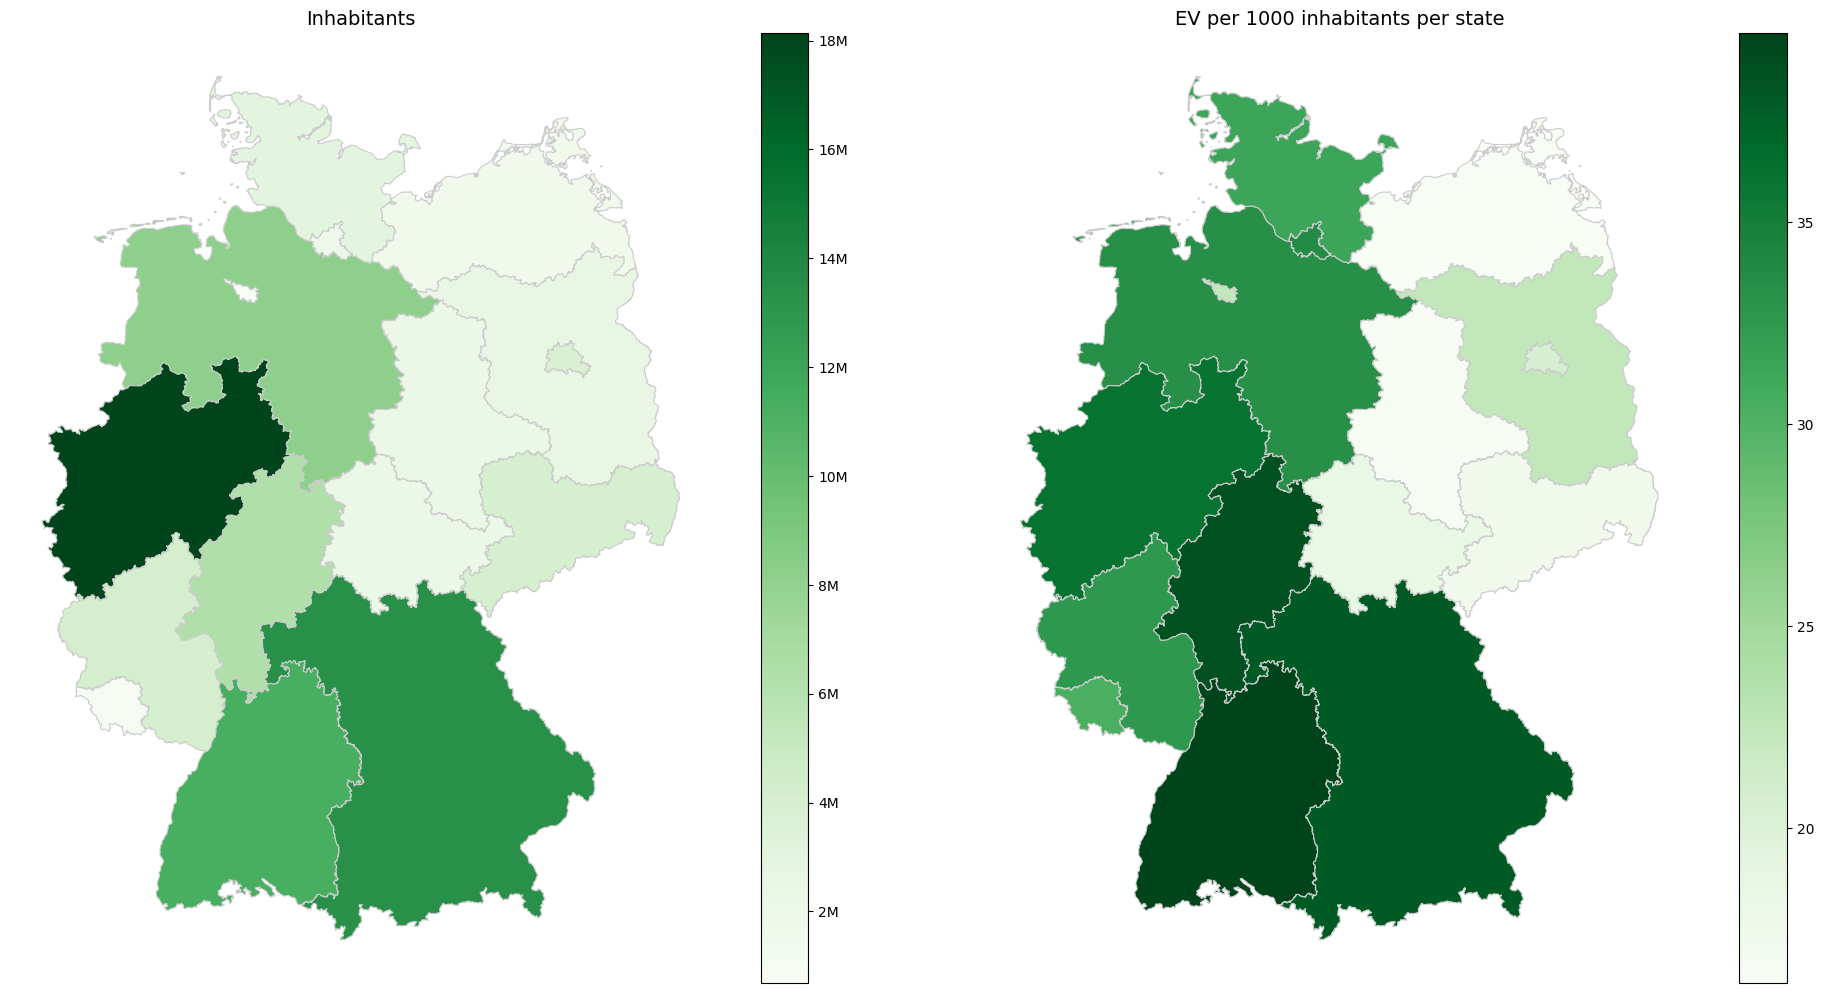

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Map 1: Charging points per km²
gdf_plot  = germany_states.plot(
    column="inhabitants",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[0]
)
axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))
axes[0].set_title("Inhabitants", fontsize=14)
axes[0].axis("off")

# Get the colorbar object from the figure
cbar = gdf_plot.get_figure().get_axes()[-1]  # last axis is the colorbar

# Apply the custom formatter to colorbar ticks
cbar.yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))


# Map 2: Population density
germany_states.plot(
    column="ev_per_1000_inhabitants",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[1]
)
axes[1].set_title("EV per 1000 inhabitants per state", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


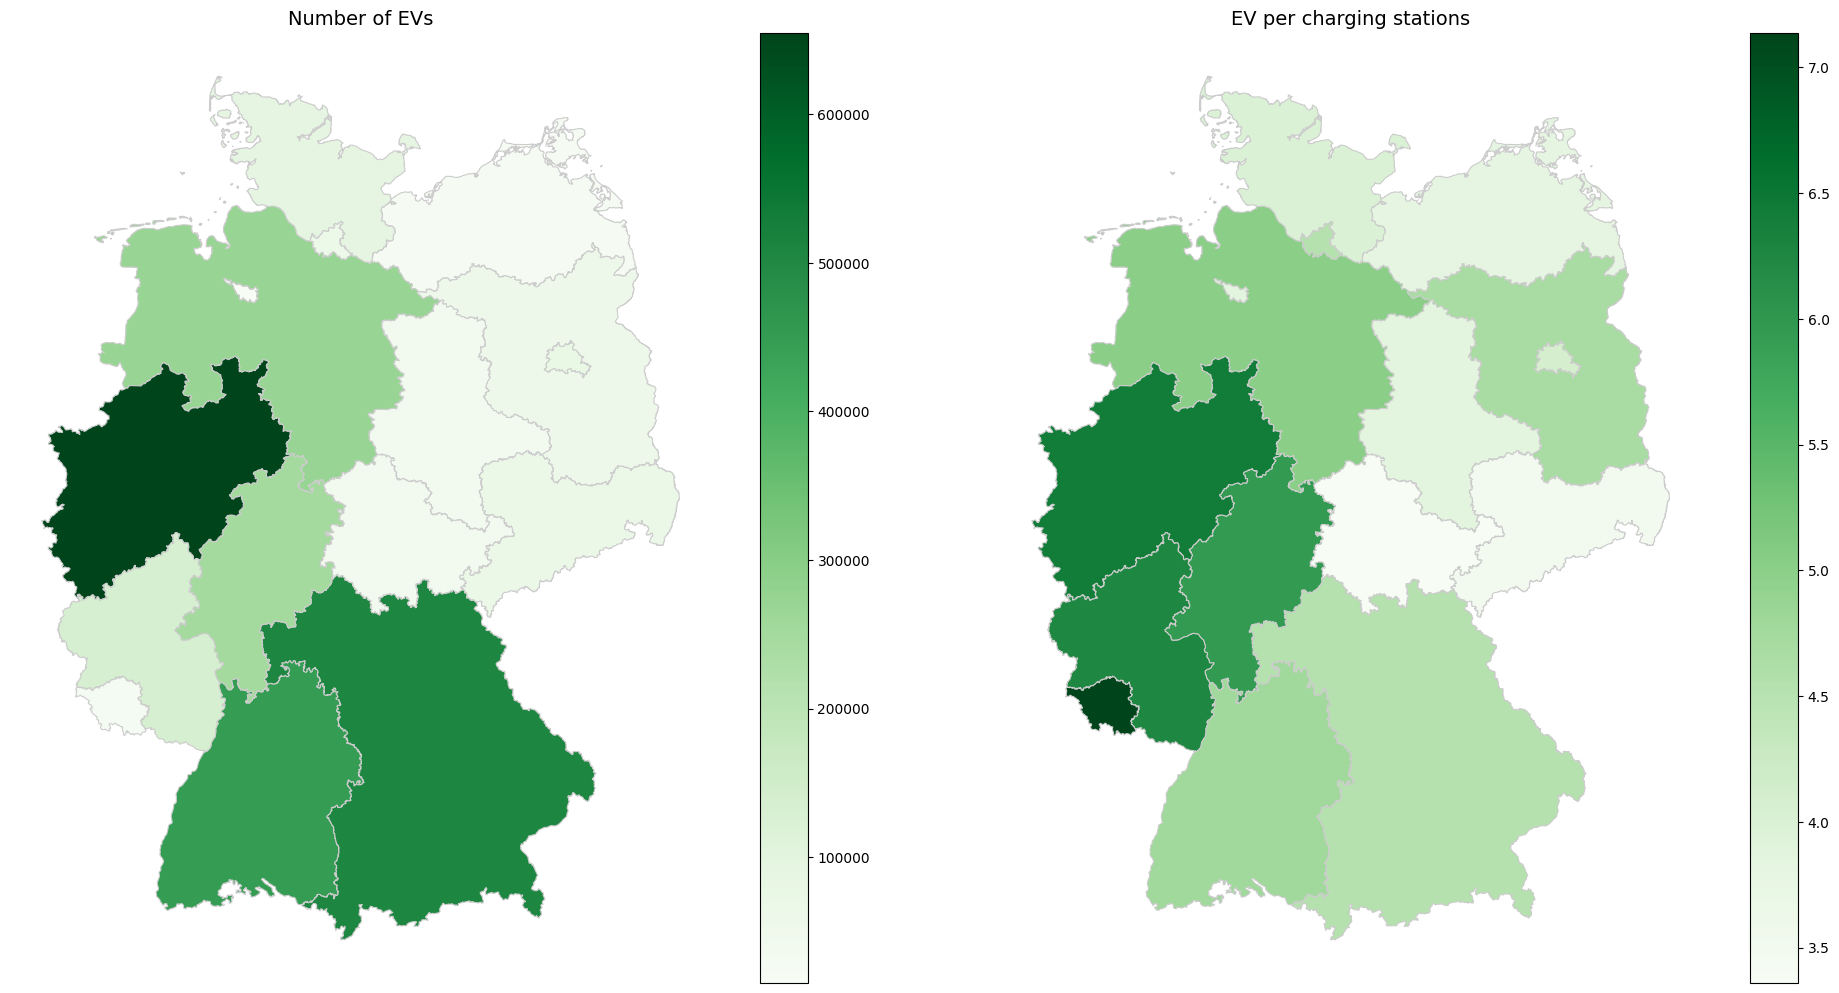

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Map 1: Charging points per km²
germany_states.plot(
    column="number_of_electric_cars",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[0]
)

axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))
axes[0].set_title("Number of EVs", fontsize=14)
axes[0].axis("off")


# Map 2: Population density
germany_states.plot(
    column="ev_per_stations",
    cmap="Greens",
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=axes[1]
)
axes[1].set_title("EV per charging stations", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()
